INFO 4330 — Text-to-SQL on Credit Card Fraud

Dmytro Poliak
Student ID: 100443432
Date: Aug 12, 2025

The goal is to:

Load the fraud.csv into SQLite with a clean schema.
Convert natural language questions into SQL using the GPT API.
Run the generated SQL and show results as a pandas dataframe.

Always print the SQL we executed, so it's clear and transparent.

In [1]:
!pip install openai

Import ChatGPT Api and configure api key

In [3]:
import openai
from openai import OpenAI
from config import api_key

In [7]:
client = OpenAI(api_key=api_key) #api key

import other packages

In [5]:
import sqlite3
import pandas as pd
from pathlib import Path
from typing import Any, Optional

print("OpenAI client ready.")

OpenAI client ready.


In [6]:
# Model name, can be changed
MODEL_NAME = "gpt-4o-mini"

In [8]:
# Paths, table name
CSV_PATH = Path("./fraud_data.csv")  # Use the uploaded file
DB_PATH = Path("./fraud.sqlite")
TABLE_NAME = "fraud_data_table"

print("CSV path set to:", CSV_PATH)

CSV path set to: fraud_data.csv


Figure out column types from the CSV so we can create the table with correct schema

In [9]:
def pandas_dtype_to_sqlite(dtype: Any) -> str:
    # Pandas dtypes can be numpy dtypes or extension dtypes. make sure correct data types are used
    if pd.api.types.is_integer_dtype(dtype):
        return "INTEGER"
    if pd.api.types.is_float_dtype(dtype):
        return "REAL"
    if pd.api.types.is_bool_dtype(dtype):
        return "INTEGER"  # store as 0/1
    # Dates often come in as object; if your CSV has date columns, you can special-case them here.
    return "TEXT"

# read a small sample
sample_df = pd.read_csv(CSV_PATH, nrows=1000)
column_types = {col: pandas_dtype_to_sqlite(sample_df[col].dtype) for col in sample_df.columns}
column_types

{'trans_date_trans_time': 'TEXT',
 'merchant': 'TEXT',
 'category': 'TEXT',
 'amt': 'REAL',
 'city': 'TEXT',
 'state': 'TEXT',
 'lat': 'REAL',
 'long': 'REAL',
 'city_pop': 'INTEGER',
 'job': 'TEXT',
 'dob': 'TEXT',
 'trans_num': 'TEXT',
 'merch_lat': 'REAL',
 'merch_long': 'REAL',
 'is_fraud': 'INTEGER'}

Create table with correct schema, then load data from CSV into SQLite

In [15]:
# Create database
conn = sqlite3.connect(DB_PATH)
cur = conn.cursor()

In [16]:
# drop table if exists already
cur.execute(f"DROP TABLE IF EXISTS {TABLE_NAME};")

In [17]:
# make list of columns
col_defs = []
for col_name, col_type in column_types.items():
    col_defs.append(f'"{col_name}" {col_type}')

# join with commas
cols_sql = ", ".join(col_defs)

In [18]:
# Create the table
create_sql = f"CREATE TABLE {TABLE_NAME} ({cols_sql});"
print(create_sql)
cur.execute(create_sql)
conn.commit()

CREATE TABLE fraud_data_table ("trans_date_trans_time" TEXT, "merchant" TEXT, "category" TEXT, "amt" REAL, "city" TEXT, "state" TEXT, "lat" REAL, "long" REAL, "city_pop" INTEGER, "job" TEXT, "dob" TEXT, "trans_num" TEXT, "merch_lat" REAL, "merch_long" REAL, "is_fraud" INTEGER);


In [19]:
# Load the full CSV
full_df = pd.read_csv(CSV_PATH)

# Create placeholders for query
placeholders = ", ".join(["?"] * len(full_df.columns))

# Create a csv list of column names, each in quotes
col_names = ", ".join([f'"{c}"' for c in full_df.columns])

# Final insert SQL
insert_sql = f"INSERT INTO {TABLE_NAME} ({col_names}) VALUES ({placeholders});"

# Insert data
cur.executemany(insert_sql, full_df.values.tolist())
conn.commit()

Schema

In [21]:
schema_rows = cur.execute(f'PRAGMA table_info({TABLE_NAME});').fetchall()
schema_df = pd.DataFrame(
    schema_rows,
    columns=["ID", "Column", "Type", "NotNull", "Default", "PrimaryKey"]
)
schema_df

,ID,Column,Type,NotNull,Default,PrimaryKey
0,0,trans_date_trans_time,TEXT,0,None,0
1,1,merchant,TEXT,0,None,0
2,2,category,TEXT,0,None,0
3,3,amt,REAL,0,None,0
4,4,city,TEXT,0,None,0
5,5,state,TEXT,0,None,0
6,6,lat,REAL,0,None,0
7,7,long,REAL,0,None,0
8,8,city_pop,INTEGER,0,None,0
9,9,job,TEXT,0,None,0


Only allow SELECT queries (no INSERT, UPDATE, DELETE, etc)

In [36]:
def run_readonly_sql(sql, conn):
    # remove extra spaces and any last semicolon
    sql = clean_sql(sql)
    sql = sql.strip()
    if sql.endswith(";"):
        sql = sql[:-1]

    # check if the query starts with SELECT (so it's read-only)
    if not sql.lower().startswith("select"):
        raise ValueError("Only SELECT queries are allowed.")

    # run the query and return results as a DataFrame
    return pd.read_sql_query(sql, conn)

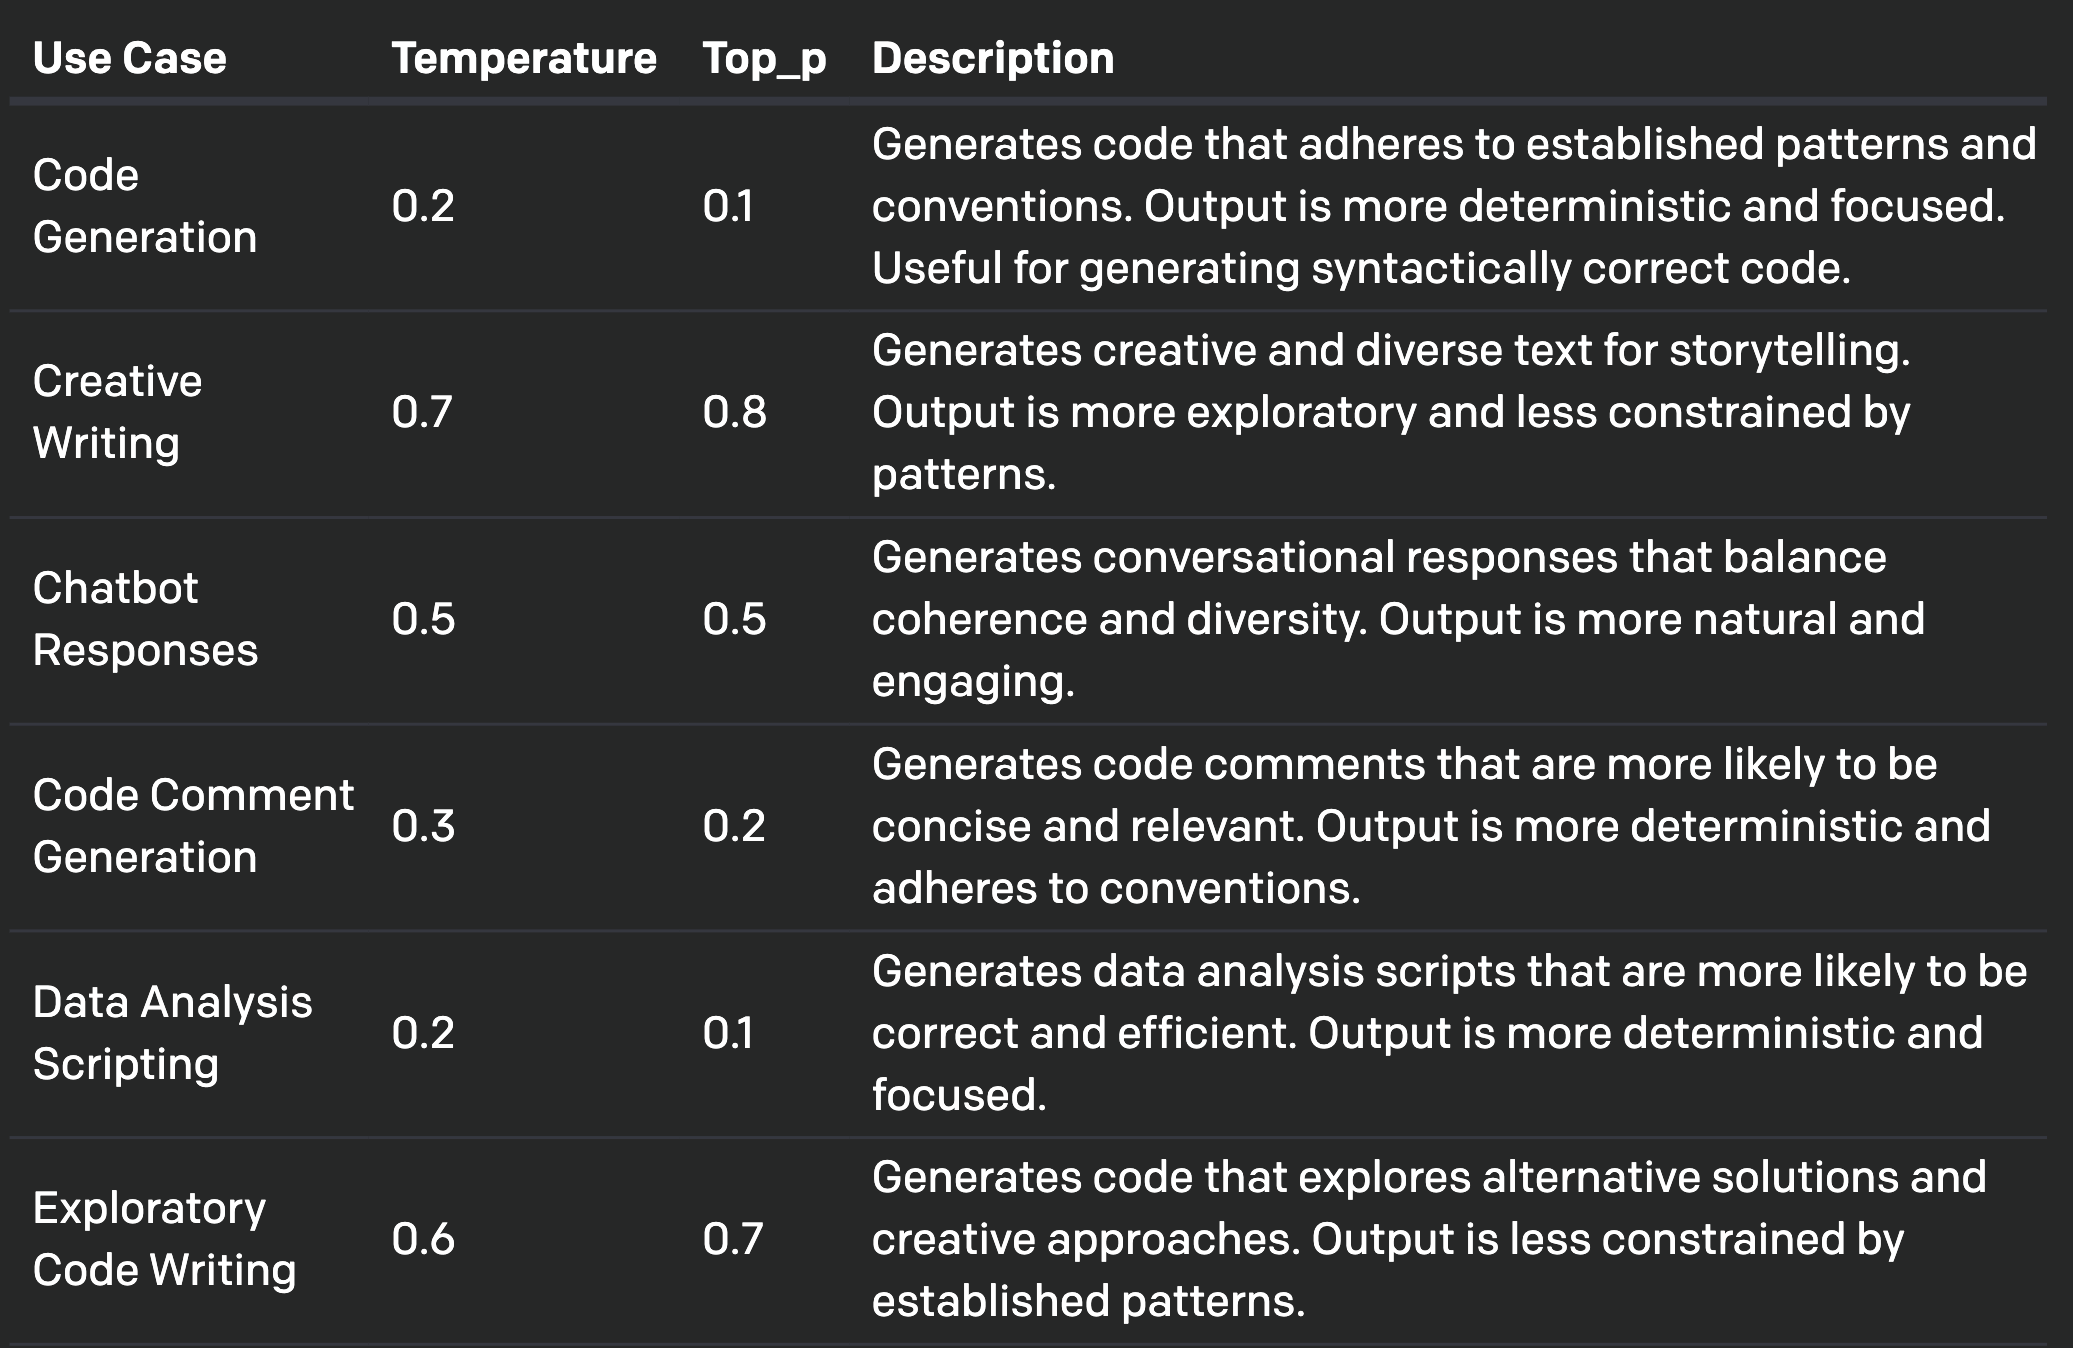

The model will be a bit more deterministic since we need a valid SQL

temperature = 0.2 - means less randomness
top_p = 0.1 - sample from the most likely tokens only

Result - stable output and fewer mistakes

Prompt short and clear

Pass the table schema and the user's question to the model, and ask it to produce a clean SQL query for SQLite.

Keep the prompt short and practical to avoid generic outputs.

In [28]:
# This builds the messages we send to the GPT model

def build_user_prompt(nl_question: str, table_name: str, schema_df: pd.DataFrame) -> str:
    # Handle both original and simplified schema column names
    name_col = "name" if "name" in schema_df.columns else ("Column" if "Column" in schema_df.columns else schema_df.columns[1])
    type_col = "type" if "type" in schema_df.columns else ("Type" if "Type" in schema_df.columns else schema_df.columns[2])

    # Make a short schema list like: column (TYPE)
    cols = [f"{row[name_col]} ({row[type_col]})" for _, row in schema_df.iterrows()]
    schema_text = "\n".join(cols)

    return (
        f"TABLE: {table_name}\n"
        f"SCHEMA (name (type)):\n{schema_text}\n\n"
        f"QUESTION: {nl_question}\n\n"
        f"Return a single SELECT query for SQLite."
    )

In [29]:
def generate_sql_from_natural_language(question: str, model: str = None) -> str:
    # System instruction kept short like in class examples
    system_text = (
        "You convert plain English into one SQLite SELECT query for a single table. "
        "Use the provided schema. Output only the SQL."
    )

    user_prompt = build_user_prompt(question, TABLE_NAME, schema_df)

    resp = client.chat.completions.create(
        model=model or MODEL_NAME,
        messages=[
            {"role": "system", "content": system_text},
            {"role": "user", "content": user_prompt},
        ],
        temperature=0.2,  # Low randomness for stable SQL
        top_p=0.1,        # Limit to most likely tokens
    )
    return resp.choices[0].message.content.strip()

In [32]:
def clean_sql(sql_text: str) -> str:
    """Remove markdown code fences and extra formatting from SQL."""
    sql_text = sql_text.strip()
    if sql_text.startswith("```"):
        # Remove triple backticks and optional 'sql'
        sql_text = sql_text.strip("`")
        sql_text = sql_text.replace("sql\n", "").replace("sql\r\n", "")
    return sql_text.strip()

Takes a natural language question, asks GPT for SQL, prints the SQL, then executes it and returns the DataFrame

In [34]:
def ask(nl_question, preview_rows=10):
    # Get SQL from GPT for my question
    #sql = generate_sql_from_natural_language(nl_question)
    raw_sql = generate_sql_from_natural_language(nl_question)
    sql = clean_sql(raw_sql)
    print("Generated SQL:\n", sql, "\n")

    # Run only if it is a SELECT and show a few rows
    df = run_readonly_sql(sql, conn)
    return df.head(preview_rows)

Examples to test and run the program




*   show all fraudulent transactions
*   total fraud amount by year
*   top 5 merchants by total fraud amount
*   filter fraud records in 2019


In [39]:
import sqlite3
import pandas as pd

# connect to your database (update with correct path if needed)
conn = sqlite3.connect("fraud.db")

def run_and_show(sql):
    print("Generated SQL:\n", sql, "\n")
    df = pd.read_sql_query(sql, conn)  # reuse the existing connection
    display(df)

# Example 1
try:
    sql1 = ask("filter the fraud records in the year 2019")
    run_and_show(sql1)
except Exception as e:
    print("Example 1 failed:", e)

# Example 2
try:
    sql2 = ask("total fraud amount by tx_year")
    run_and_show(sql2)
except Exception as e:
    print("Example 2 failed:", e)

# Example 3
try:
    sql3 = ask("top 5 merchants by total fraud amount")
    run_and_show(sql3)
except Exception as e:
    print("Example 3 failed:", e)

Generated SQL:
 SELECT * FROM fraud_data_table WHERE is_fraud = 1 AND trans_date_trans_time LIKE '2019%'; 

Example 1 failed: Execution failed on sql 'SELECT * FROM fraud_data_table WHERE is_fraud = 1 AND trans_date_trans_time LIKE '2019%'': no such table: fraud_data_table
Generated SQL:
 SELECT strftime('%Y', trans_date_trans_time) AS tx_year, SUM(amt) AS total_fraud_amount
FROM fraud_data_table
WHERE is_fraud = 1
GROUP BY tx_year; 

Example 2 failed: Execution failed on sql 'SELECT strftime('%Y', trans_date_trans_time) AS tx_year, SUM(amt) AS total_fraud_amount
FROM fraud_data_table
WHERE is_fraud = 1
GROUP BY tx_year': no such table: fraud_data_table
Generated SQL:
 SELECT merchant, SUM(amt) AS total_fraud_amount
FROM fraud_data_table
WHERE is_fraud = 1
GROUP BY merchant
ORDER BY total_fraud_amount DESC
LIMIT 5; 

Example 3 failed: Execution failed on sql 'SELECT merchant, SUM(amt) AS total_fraud_amount
FROM fraud_data_table
WHERE is_fraud = 1
GROUP BY merchant
ORDER BY total_fraud_